In [1]:
import reddit_classifiers as rc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from reddit_classifiers import util

In [2]:
def plot_goemotions_comparison(data, emotions='all', figsize=(8, 15), data_type='both', year_min=2014, window=None, names=None, external_thresholds=None, fig=None, axes=None):
    """
    Plot GoEmotions sentiments comparison across different datasets using seaborn.
    
    Args:
        data (dict): Dictionary of data dictionaries, each containing 'submissions' and 'comments' DataFrames
        emotions (str or list): 'all' for all emotions or list of specific emotions to plot
        figsize (tuple): Figure size as (width, height)
        data_type (str): 'both', 'submissions', or 'comments' to select which data to plot
        year_min (int): Minimum year to include in plot
        window (int, optional): If provided, applies a moving average with the specified window size in months
        names (dict, optional): Dictionary mapping dataset names to display names for the legend
        external_thresholds (dict, optional): Dictionary mapping emotion names to threshold values for emotions not in GoEmotions
        fig (Figure, optional): Existing figure to update
        axes (list, optional): Existing axes to update
    """
    # Get emotion thresholds
    thresholds = rc.util.get_goemotions_thresholds()
    if emotions != 'all':
        filtered_thresholds = {}
        for emotion in emotions:
            if emotion in thresholds:
                filtered_thresholds[emotion] = thresholds[emotion]
            elif external_thresholds and emotion in external_thresholds:
                filtered_thresholds[emotion] = external_thresholds[emotion]
        thresholds = filtered_thresholds
    
    # Create figure with subplots only if not provided
    n_emotions = len(thresholds)
    if fig is None or axes is None:
        fig, axes = plt.subplots(n_emotions, 1, figsize=figsize)
        if n_emotions == 1:
            axes = [axes]
        sns.set_palette("Dark2")
    
    # Track min and max dates across all data
    min_date = pd.Timestamp.max
    max_date = pd.Timestamp.min
    
    # First pass to find max y value
    max_y_value = 0
    for emotion, threshold in thresholds.items():
        for dataset_name in data.keys():
            dataset = data[dataset_name]
            data_types = ['submissions', 'comments'] if data_type == 'both' else [data_type]
            
            for dt in data_types:
                if dt in dataset and not dataset[dt].empty:
                    df = dataset[dt]
                    total = df.groupby('dataset').size()
                    above_threshold = df[df[emotion] > threshold].groupby('dataset').size()
                    values = (above_threshold / total * 100).fillna(0)
                    dates = pd.to_datetime(values.index)
                    values = values[dates.year >= year_min]
                    if window is not None:
                        values = values.rolling(window=window, min_periods=1).mean()
                    max_y_value = max(max_y_value, values.max())
    
    # Plot each emotion
    for idx, (emotion, threshold) in enumerate(thresholds.items()):
        ax = axes[idx]
        
        # Process and plot data for each dataset
        for dataset_name in data.keys():
            dataset = data[dataset_name]
            display_name = names.get(dataset_name, dataset_name) if names else dataset_name
            
            data_types = ['submissions', 'comments'] if data_type == 'both' else [data_type]
                
            for dt in data_types:
                if dt in dataset and not dataset[dt].empty:
                    df = dataset[dt]
                    total = df.groupby('dataset').size()
                    above_threshold = df[df[emotion] > threshold].groupby('dataset').size()
                    values = (above_threshold / total * 100).fillna(0)
                    dates = pd.to_datetime(values.index)
                    values = values[dates.year >= year_min]
                    dates = dates[dates.year >= year_min]
                    
                    if len(values) > 0:
                        min_date = min(min_date, dates.min())
                        max_date = max(max_date, dates.max())
                        
                        if window is not None:
                            values = values.rolling(window=window, min_periods=1).mean()
                    
                        line = sns.lineplot(
                            x=pd.to_datetime(values.index),
                            y=values,
                            ax=ax,
                            label=f'{display_name}',
                            alpha=0.7 if dt == 'submissions' else 1,
                            linewidth=2 if dt == 'submissions' else 3,
                            errorbar=None
                        )
        
        # Only set titles and format axes if this is the first time
        if len(ax.lines) <= len(data):  # Check if these are the first lines being plotted
            ax.set_title(f'{emotion.capitalize()}', pad=25)
            ax.set_ylabel('Percentage')
            ax.set_xlabel('')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper left', bbox_to_anchor=(0.0, 1.25), ncol=3, frameon=False)
        
        # Update axis limits
        ax.set_xlim(min_date, max_date)
        years = list(range(min_date.year, max_date.year + 1))
        ax.set_xticks([pd.Timestamp(year=y, month=1, day=1) for y in years])
        ax.set_xticklabels(years, rotation=45)
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
    plt.tight_layout(h_pad=1.0)
    return fig, axes

Loading comments: 100%|██████████| 228/228 [00:53<00:00,  4.23it/s]


RAW DATA:

Stats for submissions:
--------------------------------------------------
Total entries: 1,817,553
Total score sum: 163,396,245
Number of unique subreddits: 79,799

Top 5 subreddits:
  dirtypenpals: 67,206 entries (3.7%)
  furrykikpals: 66,589 entries (3.7%)
  dogecoin: 46,045 entries (2.5%)
  elon_musketeers: 37,720 entries (2.1%)
  gayrp: 31,605 entries (1.7%)

Number of unique authors: 433,072

Top 5 authors:
  [deleted]: 183,429 entries (10.1%)
  idevice_help: 37,679 entries (2.1%)
  autonewsadmin: 24,397 entries (1.3%)
  autonewspaperadmin: 21,886 entries (1.2%)
  -en-: 12,972 entries (0.7%)

Stats for comments:
--------------------------------------------------
Total entries: 9,009,782
Total score sum: 108,972,395.0
Number of unique subreddits: 54,320

Top 5 subreddits:
  wallstreetbets: 387,420 entries (4.3%)
  askreddit: 281,618 entries (3.1%)
  technology: 276,338 entries (3.1%)
  enoughmuskspam: 253,488 entries (2.8%)
  whitepeopletwitter: 246,595 entries (2.7%)

N

Loading comments: 100%|██████████| 228/228 [00:05<00:00, 45.12it/s] 


RAW DATA:

Stats for submissions:
--------------------------------------------------
Total entries: 182,238
Total score sum: 21,621,393
Number of unique subreddits: 19,713

Top 5 subreddits:
  autonewspaper: 6,368 entries (3.5%)
  technology: 4,479 entries (2.5%)
  newsbotbot: 4,257 entries (2.3%)
  the_donald: 3,539 entries (1.9%)
  news: 3,097 entries (1.7%)

Number of unique authors: 64,476

Top 5 authors:
  [deleted]: 19,358 entries (10.6%)
  autonewsadmin: 6,938 entries (3.8%)
  autonewspaperadmin: 6,368 entries (3.5%)
  -en-: 4,842 entries (2.7%)
  autotldr: 2,077 entries (1.1%)

Stats for comments:
--------------------------------------------------
Total entries: 879,099
Total score sum: 12,959,106.0
Number of unique subreddits: 21,151

Top 5 subreddits:
  technology: 56,546 entries (6.4%)
  askreddit: 43,211 entries (4.9%)
  politics: 40,209 entries (4.6%)
  wallstreetbets: 34,762 entries (4.0%)
  worldnews: 21,996 entries (2.5%)

Number of unique authors: 520,106

Top 5 author

Loading comments: 100%|██████████| 228/228 [00:05<00:00, 44.09it/s] 


RAW DATA:

Stats for submissions:
--------------------------------------------------
Total entries: 361,362
Total score sum: 12,745,346
Number of unique subreddits: 82,469

Top 5 subreddits:
  britneyspears: 12,737 entries (3.5%)
  reddit.com: 7,578 entries (2.1%)
  entertainment: 3,683 entries (1.0%)
  popheads: 3,505 entries (1.0%)
  music: 2,510 entries (0.7%)

Number of unique authors: 120,569

Top 5 authors:
  [deleted]: 24,266 entries (6.7%)
  celebnationofficial: 2,405 entries (0.7%)
  autonewsadmin: 1,915 entries (0.5%)
  autonewspaperadmin: 1,840 entries (0.5%)
  news247planet: 1,606 entries (0.4%)

Stats for comments:
--------------------------------------------------
Total entries: 841,833
Total score sum: 12,667,315
Number of unique subreddits: 23,885

Top 5 subreddits:
  askreddit: 63,012 entries (7.5%)
  popheads: 52,375 entries (6.2%)
  britneyspears: 40,827 entries (4.8%)
  biggerbosomsarebetter: 32,038 entries (3.8%)
  bigbrother: 21,988 entries (2.6%)

Number of uniqu

Loading comments: 100%|██████████| 228/228 [00:13<00:00, 17.11it/s] 


RAW DATA:

Stats for submissions:
--------------------------------------------------
Total entries: 247,895
Total score sum: 21,678,313
Number of unique subreddits: 21,807

Top 5 subreddits:
  joerogan: 36,355 entries (14.7%)
  mma: 6,680 entries (2.7%)
  thefighterandthekid: 5,730 entries (2.3%)
  videos: 4,676 entries (1.9%)
  conspiracy: 3,711 entries (1.5%)

Number of unique authors: 105,123

Top 5 authors:
  [deleted]: 38,428 entries (15.5%)
  danzabot: 2,763 entries (1.1%)
  babyyourearichman111: 1,313 entries (0.5%)
  news247planet: 1,161 entries (0.5%)
  itchyyyyscrotum: 949 entries (0.4%)

Stats for comments:
--------------------------------------------------
Total entries: 2,347,396
Total score sum: 25,885,591.0
Number of unique subreddits: 24,461

Top 5 subreddits:
  joerogan: 276,225 entries (11.8%)
  mma: 161,240 entries (6.9%)
  thefighterandthekid: 104,012 entries (4.4%)
  askreddit: 94,996 entries (4.0%)
  politics: 51,550 entries (2.2%)

Number of unique authors: 903,2

Loading comments: 100%|██████████| 228/228 [00:06<00:00, 32.78it/s] 


RAW DATA:

Stats for submissions:
--------------------------------------------------
Total entries: 166,176
Total score sum: 37,195,190
Number of unique subreddits: 17,995

Top 5 subreddits:
  memes: 7,564 entries (4.6%)
  keanubeingawesome: 7,222 entries (4.3%)
  dankmemes: 7,029 entries (4.2%)
  pewdiepiesubmissions: 6,873 entries (4.1%)
  adviceanimals: 6,709 entries (4.0%)

Number of unique authors: 83,385

Top 5 authors:
  [deleted]: 36,607 entries (22.0%)
  itchyyyyscrotum: 1,253 entries (0.8%)
  milkprogrammer: 753 entries (0.5%)
  stockad1567: 596 entries (0.4%)
  akeanusbd: 473 entries (0.3%)

Stats for comments:
--------------------------------------------------
Total entries: 1,140,127
Total score sum: 16,835,078.0
Number of unique subreddits: 23,918

Top 5 subreddits:
  askreddit: 161,374 entries (14.2%)
  movies: 65,976 entries (5.8%)
  memes: 51,744 entries (4.5%)
  cyberpunkgame: 27,562 entries (2.4%)
  dankmemes: 25,508 entries (2.2%)

Number of unique authors: 665,879


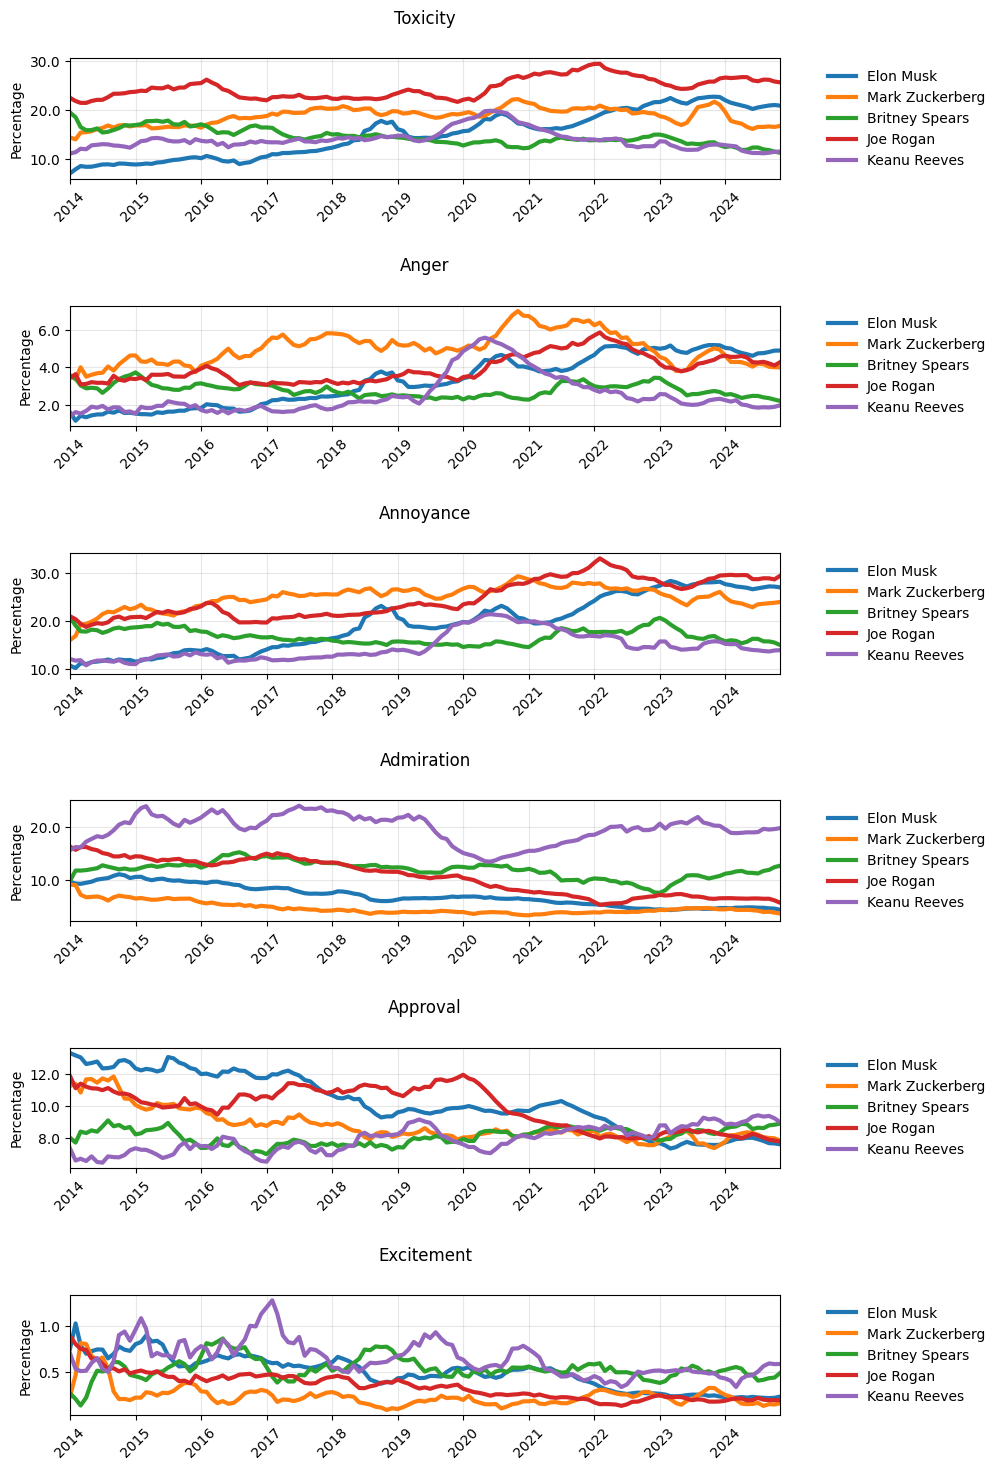

In [3]:
fig = None
axes = None
emotions = ['toxicity', 'anger', 'annoyance', 'admiration', 'approval', 'excitement']
names={'musk': 'Elon Musk', 'zuck': 'Mark Zuckerberg', 'britney': 'Britney Spears', 'rogan': 'Joe Rogan', 'keanu': 'Keanu Reeves'}
celebrities = ['musk', 'zuck', 'britney', 'rogan', 'keanu']
data = {}
for celebrity in celebrities:
    filepath = f'data/classified/{celebrity}/{{}}_{celebrity}_{{}}.csv'
    data[celebrity] = rc.util.data_pipeline(filepath, end_date='2024-11', start_date=None, data_type='both', submission_threshold=0.005, comment_threshold=0.001, word_count_threshold=20, user_threshold=0.0001, removed_users=['[deleted]', '[removed]', 'automoderator'], bot_filter=True, verbose=True)

    celebrity_data = {celebrity: data[celebrity]}
    fig, axes = plot_goemotions_comparison(
        celebrity_data, 
        emotions=emotions, 
        data_type='comments', 
        window=6, 
        names={celebrity: names[celebrity]},
        external_thresholds={'toxicity': 0.7},
        fig=fig,
        axes=axes
    )
    # Clear data after plotting
    data[celebrity] = None
for ax in axes:
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)
    ax.set_xlabel('')
    ax.set_ylabel('Percentage')
plt.show()